<h1 style="color: white; 
    font-size: 46px; 
    text-align: center; 
    background: #00ffcc; 
    padding: 30px; 
    ">Text Classification - Sarcasm</h1>

In [4]:
#!pip install tensorflow==2.0.0-alpha0 

import tensorflow as tf
print(tf.__version__)

2.0.0-alpha0


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"       
training_size = 20000

# Load the data

In [5]:
DATA_URLS = ['https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json']
DIR_NAME = 'sarcasm'
    
DATA_FILE_EXT = '.json'
DATA_DIR_PATH = './data/' + DIR_NAME

In [6]:
# !pip install wget

import os
import wget

def download_wget(URLS, FILE_EXT, DIR_PATH):
    for url in URLS:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(DIR_PATH):
            print('Downloading', url)
            wget.download(url, out=DIR_PATH)
            file_path = os.path.join(DIR_PATH, target_file)
            print('\n \nExtracting files from', file_path)
            print('\nDone!')
        else:
            print('Already downloaded', url)


if not os.path.isdir('data'):
    os.mkdir('data')    
    
if not os.path.isdir('data/' + DIR_NAME):
    os.mkdir('data/' + DIR_NAME)              

    
download_wget(DATA_URLS, DATA_FILE_EXT, DATA_DIR_PATH)

100% [......................................................] 5643545 / 5643545
 
Extracting files from ./data/sarcasm\sarcasm.json

Done!


# Training and testing set

In [10]:
with open("./data/sarcasm/sarcasm.json", 'r') as f:
    datastore = json.load(f)
    
sentences = []
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [11]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Text preprocessing

In [12]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

In [13]:
word_index = tokenizer.word_index

In [14]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# The model

In [15]:
model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 24)                1560      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 30,129
Trainable params: 30,129
Non-trainable params: 0
_________________________________________________________________


In [16]:
model_CONV = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_CONV.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 29,489
Trainable params: 29,489
Non-trainable params: 0
_________________________________________________________________


In [19]:
model = model_CONV

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [20]:
num_epochs = 50
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)

Train on 20000 samples, validate on 6709 samples
Epoch 1/50
20000/20000 [==============================] - 14s 694us/sample - loss: 0.4735 - accuracy: 0.7586 - val_loss: 0.4135 - val_accuracy: 0.8095
Epoch 2/50
20000/20000 [==============================] - 10s 514us/sample - loss: 0.3594 - accuracy: 0.8406 - val_loss: 0.3905 - val_accuracy: 0.8240
Epoch 3/50
20000/20000 [==============================] - 11s 544us/sample - loss: 0.3240 - accuracy: 0.8557 - val_loss: 0.3917 - val_accuracy: 0.8229
Epoch 4/50
20000/20000 [==============================] - 10s 499us/sample - loss: 0.2919 - accuracy: 0.8718 - val_loss: 0.3990 - val_accuracy: 0.8246
Epoch 5/50
20000/20000 [==============================] - 10s 520us/sample - loss: 0.2609 - accuracy: 0.8899 - val_loss: 0.4192 - val_accuracy: 0.8182
Epoch 6/50
20000/20000 [==============================] - 12s 612us/sample - loss: 0.2295 - accuracy: 0.9058 - val_loss: 0.4427 - val_accuracy: 0.8183
Epoch 7/50
20000/20000 [=====================

# Plot the results

<Figure size 432x288 with 0 Axes>

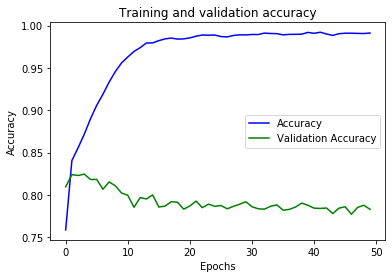

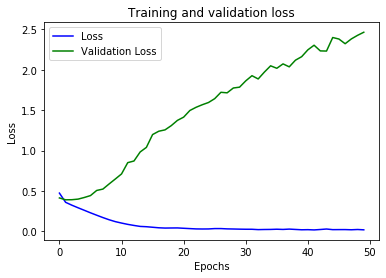

<Figure size 432x288 with 0 Axes>

In [25]:
%matplotlib inline

import matplotlib.pyplot as plt


# Retrieve the results on training and test data sets for each training epoch
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs


# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'b')
plt.plot(epochs, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()


# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, tokenizer.vocab_size):
    word = tokenizer.decode([word_num])
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")

out_v.close()
out_m.close()

#from colab import files
#files.download('vecs.tsv')
#files.download('meta.tsv')

# Predictions

In [ ]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))